# SS GLM 

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.


## Train a model with sklearn 

Replicate the same experiment from sklearn [tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims) on insurance claims using sf ss glm.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from functools import partial
from sklearn.datasets import fetch_openml
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)


def load_mtpl2(n_samples=None):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=None
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True).data
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True).data

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

df = load_mtpl2()

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

/home/zoupeicheng.zpc/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/home/zoupeicheng.zpc/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139.0      1.0      0.75    F       7.0     1.0     61.0        50.0      B12   
190.0      1.0      0.14    B      12.0     5.0     50.0        60.0      B12   
414.0      1.0      0.14    E       4.0     0.0     36.0        85.0      B12   
424.0      2.0      0.62    F      10.0     0.0     51.0       100.0      B12   
463.0      1.0      0.31    A       5.0     0.0     45.0        50.0      B12   

        VehGas  Density Region  ClaimAmount   PurePremium  Frequency  \
IDpol                                                                  
139.0  Regular  27000.0    R11       303.00    404.000000   1.333333   
190.0   Diesel     56.0    R25      1981.84  14156.000000   7.142857   
414.0  Regular   4792.0    R11      1456.55  10403.928571   7.142857   
424.0  Regular  27000.0    R11     10834.00  17474.193548   3.225806   


In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

### Fit the GLM model (tweedie)


In [4]:
from sklearn.linear_model import TweedieRegressor

glm_pure_premium = TweedieRegressor(power=1.9, alpha=0.1, solver='newton-cholesky')
glm_pure_premium.fit(
    X_train, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("TweedieRegressor"),
)
print("Evaluation of the Product Model and the Tweedie Regressor on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                                      T              
subset                            train          test
metric                                               
D² explained               1.690000e-02  1.420000e-02
mean Tweedie dev p=1.5000  7.640770e+01  7.640880e+01
mean Tweedie dev p=1.7000  3.682880e+01  3.692270e+01
mean Tweedie dev p=1.8000  3.037600e+01  3.045390e+01
mean Tweedie dev p=1.9000  3.382120e+01  3.387830e+01
mean Tweedie dev p=1.9900  2.015347e+02  2.015587e+02
mean Tweedie dev p=1.9990  1.914538e+03  1.914387e+03
mean Tweedie dev p=1.9999  1.904747e+04  1.904558e+04
mean abs. error            2.739865e+02  2.731249e+02
mean squared error         3.295505e+07  3.213056e+07


In [5]:
n_iter = glm_pure_premium.n_iter_

### Fit the SS GLM model (tweedie)


In [6]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob'], address='local')

alice, bob = sf.PYU('alice'), sf.PYU('bob')
spu = sf.SPU(
    sf.utils.testing.cluster_def(
        ['alice', 'bob'],
        {"protocol": "REF2K", "field": "FM128", "fxp_fraction_bits": 40},
    ),
)

The version of SecretFlow: 1.4.0.dev20240130


2024-02-19 14:19:08,097	INFO worker.py:1538 -- Started a local Ray instance.


In [7]:
from secretflow.data import FedNdarray, PartitionWay

x, y = X_train, df_train["PurePremium"]
w = df_train["Exposure"]


def x_to_vdata(x):
    x = x.todense()
    v_data = FedNdarray(
        partitions={
            alice: alice(lambda: x[:, :15])(),
            bob: bob(lambda: x[:, 15:])(),
        },
        partition_way=PartitionWay.VERTICAL,
    )
    return v_data


v_data = x_to_vdata(x)

label_data = FedNdarray(
    partitions={alice: alice(lambda: y.values)()},
    partition_way=PartitionWay.VERTICAL,
)

sample_weight = FedNdarray(
    partitions={alice: alice(lambda: w.values)()},
    partition_way=PartitionWay.VERTICAL,
)

In [8]:
from secretflow.device.driver import reveal
from secretflow.ml.linear.ss_glm.core import get_dist

dist = 'Tweedie'
ss_glm_power = 1.9


class DirectRevealModel:
    def __init__(self, model) -> None:
        self.model = model

    def predict(self, X):
        vdata = x_to_vdata(X)
        y = self.model.predict(vdata)
        return reveal(y).reshape((-1,))

    def score(self, X, y, sample_weight=None):
        y = y.values
        y_pred = self.predict(X)

        constant = np.mean(y)
        if sample_weight is not None:
            constant *= sample_weight.shape[0] / np.sum(sample_weight)

        # Missing factor of 2 in deviance cancels out.
        deviance = get_dist(dist, 1, ss_glm_power).deviance(y_pred, y, None)
        deviance_null = get_dist(dist, 1, ss_glm_power).deviance(
            np.average(y, weights=sample_weight) + np.zeros(y.shape), y, None
        )
        return 1 - (deviance + constant) / (deviance_null + constant)

In [9]:
import time
from secretflow.ml.linear.ss_glm import SSGLM

model = SSGLM(spu)

ss_glm_power = 1.9
start = time.time()
model.fit_irls(
    v_data,
    label_data,
    None,
    sample_weight,
    n_iter,
    'Log',
    'Tweedie',
    ss_glm_power,
    l2_lambda=0.1,
    infeed_batch_size_limit=10000000,
    fraction_of_validation_set=0.2,
    stopping_rounds=2,
    stopping_metric='deviance',
    stopping_tolerance=0.001,
)

wrapped_model = DirectRevealModel(model)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_ss_glm_pure_premium = score_estimator(
    wrapped_model,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_glm_pure_premium, scores_ss_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("TweedieRegressor", "SSGLMRegressor"),
)
print("Evaluation of the Tweedie Regressor and SS GLM on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

(_run pid=2434553) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=2434553) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=2434553) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
(_run pid=2434553) INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
(_run pid=2434553) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=2435206) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=24

(_run pid=2435206) [2024-02-19 14:19:16.647] [info] [thread_pool.cc:30] Create a fixed thread pool with size 63


INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO:root:irls calculating partials...
(_run pid=2434836) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=2434836) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=2434836) INFO:jax._src.xla_bri

(_run pid=2434836) [2024-02-19 14:19:17.967] [info] [thread_pool.cc:30] Create a fixed thread pool with size 63
(_run pid=2434553) [2024-02-19 14:19:17.942] [info] [thread_pool.cc:30] Create a fixed thread pool with size 63
(SPURuntime(device_id=None, party=bob) pid=2440722) 2024-02-19 14:19:18.332 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 63
(SPURuntime(device_id=None, party=alice) pid=2440721) 2024-02-19 14:19:18.332 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 63


INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls updating weights...
INFO:root:epoch 1 train times: 12.098223447799683s
INFO:root:epoch 1 validation time cost: 1.5343642234802246
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls updating weights...
INFO:root:epoch 2 train times: 2.2774670124053955s
INFO:root:epoch 2 validation time cost: 0.1729907989501953
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls updating weights...
INFO:root:epoch 3 train times: 2.3008642196655273s
INFO:root:epoch 3 validation time cost: 0.06878900527954102
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls calculating partials...
INFO:root:irls cal

Evaluation of the Tweedie Regressor and SS GLM on target PurePremium
                          TweedieRegressor                SSGLMRegressor                  
subset                               train          test           train              test
metric                                                                                    
D² explained                  1.690000e-02  1.420000e-02      0.05068153       0.048805773
mean Tweedie dev p=1.5000     7.640770e+01  7.640880e+01       86.860509         87.740697
mean Tweedie dev p=1.7000     3.682880e+01  3.692270e+01       39.502311         39.821511
mean Tweedie dev p=1.8000     3.037600e+01  3.045390e+01       31.768926         31.962367
mean Tweedie dev p=1.9000     3.382120e+01  3.387830e+01        34.55947         34.675264
mean Tweedie dev p=1.9900     2.015347e+02  2.015587e+02      201.957253        202.012602
mean Tweedie dev p=1.9990     1.914538e+03  1.914387e+03     1914.937731        1914.81592
mean Tweedie dev p=1.

In [10]:
res = []
for subset_label, x, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, tweedie, power=%.2f"
            % glm_pure_premium.power: np.sum(exposure * glm_pure_premium.predict(x)),
            "predicted, ss glm, power=%.2f"
            % ss_glm_power: np.sum(exposure * wrapped_model.predict(x)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                 train          test
observed                        3.917618e+07  1.299546e+07
predicted, tweedie, power=1.90  3.951751e+07  1.325198e+07
predicted, ss glm, power=1.90   1.452159e+08  5.445649e+07


[]

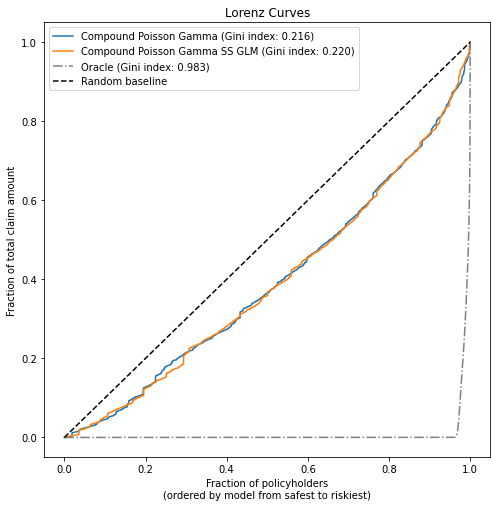

In [11]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_total_ss_glm = wrapped_model.predict(X_test).reshape((-1,))
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [
    ("Compound Poisson Gamma", y_pred_total),
    ("Compound Poisson Gamma SS GLM", y_pred_total_ss_glm),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()